In [1]:
import pandas as pd

expo = pd.read_excel("ExpoArchive_cleaned.xlsx")
purchasing = pd.read_excel("PurchasingTool_cleaned.xlsx")
scorecard = pd.read_excel('Scorecard_cleaned.xlsx')

In [2]:
# aggregate expo

def expo_aggregate(data, groupby):
    aggregate = pd.DataFrame()

    aggregate['avg_late_need'] = data.groupby(groupby)['Late Need'].mean()
    aggregate['avg_late_performance'] = data.groupby(groupby)['Late Performance'].mean()


    aggregate['num_late_need'] = data.groupby(groupby)['Late Need'].apply(lambda x: x[x > 0].count())
    aggregate['num_late_performance'] = data.groupby(groupby)['Late Performance'].apply(lambda x: x[x > 0].count())
    aggregate['num_critical'] = data.groupby(groupby)['Late Performance'].apply(lambda x: x[x == True].count())
    aggregate['num_orders'] = data.groupby(groupby)['Late Need'].count()


    aggregate['%_late_need'] = aggregate['num_late_need'] / aggregate['num_orders']
    aggregate['%_late_performance'] = aggregate['num_late_performance'] / aggregate['num_orders']
    aggregate['%_critical'] = aggregate['num_critical'] / aggregate['num_orders']

    aggregate = aggregate.drop(['num_late_performance'], axis=1)
    aggregate = aggregate.drop(['num_late_need'], axis=1)
    aggregate = aggregate.drop(['num_critical'], axis=1)


    aggregate['Vendor Code'] = aggregate.index
    aggregate.index = range(len(aggregate))
    
    return aggregate



In [3]:
# aggregate purchasing


def purchasing_aggregate(data, groupby):

    aggregate = pd.DataFrame()
    aggregate['avg_stdcost'] = data.groupby(groupby)['StdCost'].mean()
    aggregate['avg_pocost'] = data.groupby(groupby)['PoCost'].mean()
    aggregate['avg_qty'] = data.groupby(groupby)['Qty'].mean()
    aggregate['avg_costsave'] = data.groupby(groupby)['InternalCostSavings'].mean()
    aggregate['avg_spend'] = data.groupby(groupby)['Spend'].mean()
    aggregate['max_spend'] = data.groupby(groupby)['Spend'].max()
    aggregate['avg_leadtime'] = data.groupby(groupby)['PurchLeadTime'].mean()


    aggregate['num_orders'] = data.groupby(groupby)['Part'].count()

    aggregate['num_a_priority'] = data.groupby(groupby)['ABC'].apply(lambda x: x[x == 'A'].count())
    aggregate['num_b_priority'] = data.groupby(groupby)['ABC'].apply(lambda x: x[x == 'B'].count())
    aggregate['num_c_priority'] = data.groupby(groupby)['ABC'].apply(lambda x: x[x == 'C'].count())

    aggregate['%_a_priority'] = aggregate['num_a_priority'] / aggregate['num_orders']
    aggregate['%_b_priority'] = aggregate['num_b_priority'] / aggregate['num_orders']
    aggregate['%_c_priority'] = aggregate['num_c_priority'] / aggregate['num_orders']

    aggregate = aggregate.drop('num_a_priority', axis = 1)
    aggregate = aggregate.drop('num_b_priority', axis = 1)
    aggregate = aggregate.drop('num_c_priority', axis = 1)


    aggregate['Vendor Code'] = aggregate.index
    aggregate.index = range(len(aggregate))
    
    return aggregate

          

In [11]:
scorecard.head()

,Vendor Code,Period,QualityScore,QualityRating,DeliveryScore,DeliveryRating,TotalScore,TotalRating
0,49,201608,5,Gold,1,Red,3.0,Bronze
1,540,201608,5,Gold,5,Gold,5.0,Gold
2,612,201608,5,Gold,5,Gold,5.0,Gold
3,630,201608,5,Gold,5,Gold,5.0,Gold
4,920,201608,5,Gold,5,Gold,5.0,Gold


In [4]:
# aggregate scorecard

def scorecard_aggregate(data, groupby):

    bad_periods = ['Current Fiscal Year', 'Previous Fiscal Year', 'Last 12 Complete Periods', 'Current Period']
    bad_index = []
    for i in range(len(scorecard)):
        if scorecard.iloc[i]['Period'] in bad_periods:
            bad_index = bad_index + [i]

    data = data.drop(bad_index)

    aggregate = pd.DataFrame()

    aggregate['avg_quality'] = data.groupby(groupby)['QualityScore'].mean()
    aggregate['avg_delivery'] = data.groupby(groupby)['DeliveryScore'].mean()

    aggregate['Vendor Code'] = aggregate.index
    aggregate.index = range(len(aggregate))
    
    return aggregate
    

In [5]:
vc_aggregate_expo = expo_aggregate(expo, ['Vendor Code'])
vc_aggregate_purchasing = purchasing_aggregate(purchasing, ['Vendor Code'])
vc_aggregate_scorecard = scorecard_aggregate(scorecard, ['Vendor Code'])

vc_part_aggregate_expo = expo_aggregate(expo, ['Vendor Code', 'Part Number'])
vc_part_aggregate_purchasing = purchasing_aggregate(purchasing, ['Vendor Code', 'Part'])

# split vendor code and part number
vc_part_aggregate_expo['Part'] = [d[1] for d in vc_part_aggregate_expo['Vendor Code']]
vc_part_aggregate_expo['Vendor Code'] = [d[0] for d in vc_part_aggregate_expo['Vendor Code']]

vc_part_aggregate_purchasing['Part'] = [d[1] for d in vc_part_aggregate_purchasing['Vendor Code']]
vc_part_aggregate_purchasing['Vendor Code'] = [d[0] for d in vc_part_aggregate_purchasing['Vendor Code']]


print len(vc_aggregate_expo)
print len(vc_aggregate_purchasing)
print len(vc_aggregate_scorecard)

print len(vc_part_aggregate_expo)
print len(vc_part_aggregate_purchasing)




371
498
914
12956
25704


In [6]:
# merge vendor aggregates

vendor_join = vc_aggregate_expo.merge(vc_aggregate_purchasing, on = ['Vendor Code'], how = 'inner')
vendor_join = vendor_join.merge(vc_aggregate_scorecard, on = ['Vendor Code'], how = 'inner')
print len(vendor_join)
vendor_join

342


,avg_late_need,avg_late_performance,num_orders_x,%_late_need,%_late_performance,%_critical,Vendor Code,avg_stdcost,avg_pocost,avg_qty,avg_costsave,avg_spend,max_spend,avg_leadtime,num_orders_y,%_a_priority,%_b_priority,%_c_priority,avg_quality,avg_delivery
0,-10.500000,-186.500000,2,0.000000,0.000000,0.000000,83,7.149703,7.050000,650.000000,-140.908705,4606.500000,7290.00,120.000000,4,0.000000,0.000000,1.000000,5.000000,5.000000
1,0.000000,0.000000,5,0.000000,0.000000,0.000000,612,1.371250,1.369167,782.333333,2.003616,238.173333,894.72,17.083333,12,0.000000,0.000000,1.000000,5.000000,4.416667
2,-8.737500,-9.150000,80,0.237500,0.300000,0.037500,630,509.442744,511.207407,25.696296,-583.903704,12730.237037,58200.00,70.311111,135,0.696296,0.059259,0.244444,4.956522,3.434783
3,0.000000,1.428571,7,0.285714,0.428571,0.000000,920,0.807333,1.055333,6986.666667,2955.464687,7200.600000,11800.00,30.000000,15,0.933333,0.000000,0.066667,5.000000,4.583333
4,2.000000,-4.700000,10,0.300000,0.000000,0.000000,1056,38.570905,38.449774,87.454774,-183.908878,3223.768342,35630.00,79.427136,398,0.984925,0.000000,0.015075,5.000000,4.750000
5,-52.466667,-51.066667,15,0.200000,0.333333,0.066667,1212,176.253618,179.863636,14.863636,197.382349,3962.636364,33376.00,119.000000,22,0.000000,0.363636,0.636364,5.000000,4.294118
6,658.180000,659.640000,50,0.320000,0.440000,0.020000,1250,127.023714,164.612917,45.500000,-38.327268,2605.765416,24912.00,52.333333,24,0.000000,0.041667,0.958333,4.458333,2.250000
7,-0.279528,-0.330709,254,0.094488,0.098425,0.003937,1396,4.326191,5.468762,885.444015,553.962271,688.110348,33315.80,44.146718,518,0.027027,0.081081,0.891892,5.000000,3.416667
8,-69.400000,1.200000,5,0.000000,0.200000,0.000000,1447,7.525217,7.525217,1200.000000,0.122054,9030.260870,9060.00,42.130435,23,0.521739,0.478261,0.000000,5.000000,3.666667
9,15.395833,-7.291667,48,0.145833,0.104167,0.000000,1489,52.810900,52.775373,12.001570,22.086757,1171.903608,175480.00,135.115626,5094,0.694543,0.249706,0.055752,4.458333,4.500000


In [7]:
# merge vendor/part aggregates

vendor_part_join = vc_part_aggregate_expo.merge(vc_part_aggregate_purchasing, on = ['Vendor Code', 'Part'], how = 'inner')
vendor_part_join = vendor_part_join.merge(vc_aggregate_scorecard, on = ['Vendor Code'], how = 'inner')
print len(vendor_part_join)
vendor_part_join

10109


,avg_late_need,avg_late_performance,num_orders_x,%_late_need,%_late_performance,%_critical,Vendor Code,Part,avg_stdcost,avg_pocost,...,avg_costsave,avg_spend,max_spend,avg_leadtime,num_orders_y,%_a_priority,%_b_priority,%_c_priority,avg_quality,avg_delivery
0,-10.500000,-186.500000,2,0.000000,0.000000,0.000000,83,10511-2928-11,7.29000,7.130000,...,-177.211600,5915.000000,7290.000000,120.0,3,0.0,0.0,1.0,5.000000,5.000000
1,0.000000,0.000000,1,0.000000,0.000000,0.000000,612,12071-0100-01,4.66000,4.660000,...,-1.636963,447.360000,894.720000,20.0,3,0.0,0.0,1.0,5.000000,4.416667
2,0.000000,0.000000,1,0.000000,0.000000,0.000000,612,12071-0101-01,0.66000,0.660000,...,-2.157876,33.000000,49.500000,20.0,2,0.0,0.0,1.0,5.000000,4.416667
3,0.000000,0.000000,3,0.000000,0.000000,0.000000,612,P70-0002-001,0.16500,0.161429,...,4.752862,207.142857,320.000000,15.0,7,0.0,0.0,1.0,5.000000,4.416667
4,-31.272727,-69.545455,11,0.363636,0.181818,0.090909,630,10400-0422-01,524.74630,529.218750,...,-911.218750,8975.500000,27500.000000,70.0,32,0.0,0.0,1.0,4.956522,3.434783
5,-12.068966,-0.482759,29,0.137931,0.172414,0.000000,630,10400-0422-02,485.00000,485.000000,...,-490.212766,14859.574468,58200.000000,70.0,94,1.0,0.0,0.0,4.956522,3.434783
6,0.000000,-5.333333,3,0.000000,0.333333,0.000000,630,10400-0422-03,716.61110,727.000000,...,-273.000000,3816.750000,10905.000000,70.0,8,0.0,1.0,0.0,4.956522,3.434783
7,6.333333,4.666667,3,0.333333,0.666667,0.000000,920,J60-0018-002,0.82000,1.085714,...,3166.569307,7710.428571,11800.000000,30.0,14,1.0,0.0,0.0,5.000000,4.583333
8,-15.000000,-12.000000,1,0.000000,0.000000,0.000000,1056,10511-4525-01,124.63000,119.130000,...,-1626.720050,2647.736667,5113.350000,56.0,6,0.0,0.0,1.0,5.000000,4.750000
9,3.142857,-5.000000,7,0.285714,0.000000,0.000000,1056,12097-4004-01,71.26000,71.260000,...,0.000000,11792.104800,35630.000000,84.0,25,1.0,0.0,0.0,5.000000,4.750000


In [9]:
vendor_join.to_excel('vendor_join.xlsx', index= False)
vendor_part_join.to_excel('vendor_part_join.xlsx', index= False)

In [71]:
join = join.drop('Vendor Code', axis = 1)

In [75]:
join

,avg_late_need,avg_late_performance,num_orders_x,%_late_need,%_late_performance,%_critical,avg_stdcost,avg_pocost,avg_qty,avg_costsave,avg_spend,avg_leadtime,num_orders_y,%_a_priority,%_b_priority,%_c_priority,avg_quality,avg_delivery
0,-10.500000,-186.500000,2,0.000000,0.000000,0.000000,7.149703,7.050000,650.000000,-140.908705,4606.500000,120.000000,4,0.000000,0.000000,1.000000,5.000000,5.000000
1,0.000000,0.000000,5,0.000000,0.000000,0.000000,1.371250,1.369167,782.333333,2.003616,238.173333,17.083333,12,0.000000,0.000000,1.000000,5.000000,4.416667
2,-8.737500,-9.150000,80,0.237500,0.300000,0.037500,509.442744,511.207407,25.696296,-583.903704,12730.237037,70.311111,135,0.696296,0.059259,0.244444,4.956522,3.434783
3,0.000000,1.428571,7,0.285714,0.428571,0.000000,0.807333,1.055333,6986.666667,2955.464687,7200.600000,30.000000,15,0.933333,0.000000,0.066667,5.000000,4.583333
4,2.000000,-4.700000,10,0.300000,0.000000,0.000000,38.570905,38.449774,87.454774,-183.908878,3223.768342,79.427136,398,0.984925,0.000000,0.015075,5.000000,4.750000
5,-52.466667,-51.066667,15,0.200000,0.333333,0.066667,176.253618,179.863636,14.863636,197.382349,3962.636364,119.000000,22,0.000000,0.363636,0.636364,5.000000,4.294118
6,658.180000,659.640000,50,0.320000,0.440000,0.020000,127.023714,164.612917,45.500000,-38.327268,2605.765416,52.333333,24,0.000000,0.041667,0.958333,4.458333,2.250000
7,-0.279528,-0.330709,254,0.094488,0.098425,0.003937,4.326191,5.468762,885.444015,553.962271,688.110348,44.146718,518,0.027027,0.081081,0.891892,5.000000,3.416667
8,-69.400000,1.200000,5,0.000000,0.200000,0.000000,7.525217,7.525217,1200.000000,0.122054,9030.260870,42.130435,23,0.521739,0.478261,0.000000,5.000000,3.666667
9,15.395833,-7.291667,48,0.145833,0.104167,0.000000,52.810900,52.775373,12.001570,22.086757,1171.903608,135.115626,5094,0.694543,0.249706,0.055752,4.458333,4.500000


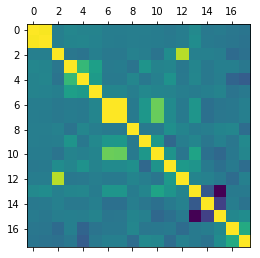

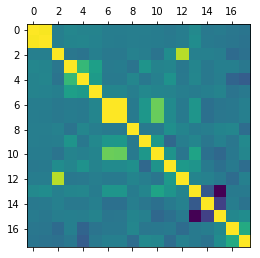

In [74]:
from sklearn.preprocessing import scale
join_scaled = scale(join)
join_scaled = pd.DataFrame(join_scaled)

import matplotlib.pyplot as plt

plt.matshow(join_scaled.corr())
plt.show()

In [76]:
join.to_excel('aggregate_join.xlsx', index= False)